In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
from astropy.table import Table
from mica.vv import get_rms_data
from chandra_aca.dark_model import get_warm_fracs
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime

In [2]:
rms_data = Table(get_rms_data())


In [3]:
rms_data = rms_data[(rms_data['isdefault'] == 1)
                    & (rms_data['type'] == b'GUIDE')
                    & (rms_data['used'] == 1)
                    & (rms_data['tstart'] > DateTime('2008:001').secs)
                    ]

In [4]:
obs_by_obsid = rms_data.group_by('obsid')
obs_min = obs_by_obsid[['obsid', 'dr_rms','dy_rms', 'dz_rms','tstart', 'mean_aacccdpt']].groups.aggregate(np.min)

In [5]:
limit = 200

In [6]:
warm_frac = []
for row in obs_min:
    frac = get_warm_fracs(limit, row['tstart'], row['mean_aacccdpt'])
    warm_frac.append(frac)
obs_min['warm_frac'] = np.array(warm_frac)

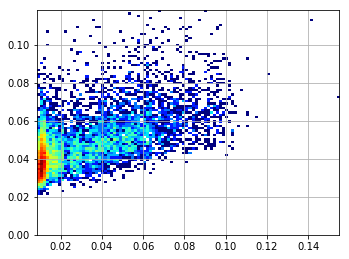

In [7]:
norm = mpl.colors.LogNorm()
my_cm = cm.jet
fig = plt.figure(figsize=(6,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=100, range=[[np.min(obs_min['warm_frac']), np.max(obs_min['warm_frac'])],
                     [0, np.percentile(obs_min['dr_rms'], 99.9)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)
plt.grid()

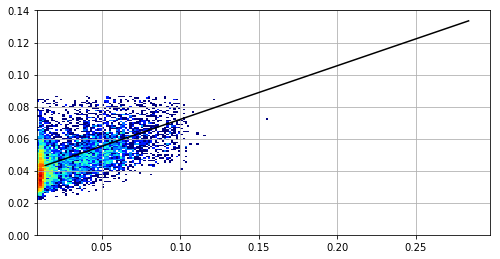

In [8]:

fig = plt.figure(figsize=(9,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=100, range=[[np.min(obs_min['warm_frac']), np.max(obs_min['warm_frac'])],
                     [0.0, np.percentile(obs_min['dr_rms'], 98)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)

# limit to just interesting fracs and fit the mean                                              
min_frac = get_warm_fracs(limit, '2010:001', -19)
ok = obs_min['warm_frac'] > min_frac
p = np.polyfit(obs_min['warm_frac'][ok], obs_min['dr_rms'][ok], 1)
w = get_warm_fracs(limit, '2022:001', -5)
x = np.arange(min_frac, w + (.05 * w), 0.01)
plt.plot(x, np.polyval(p, x), 'k', label='mean')
plt.grid(True)

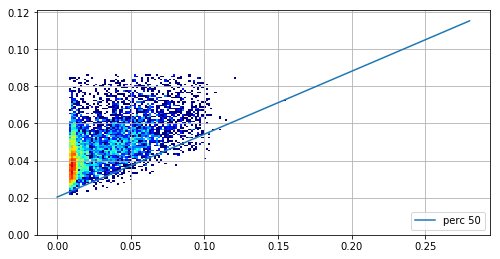

In [9]:


fig = plt.figure(figsize=(9,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=100, range=[[np.min(obs_min['warm_frac']), np.max(obs_min['warm_frac'])],
                     [0.0, np.percentile(obs_min['dr_rms'], 98)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)

percentile = 50
percs = []
bins = []
for fbin in np.arange(0, 0.25, 0.01):
    ok = (obs_min['warm_frac'] >= fbin) & (obs_min['warm_frac'] < fbin + 0.01)
    cnts = obs_min[ok]
    if len(cnts) < 100:
        continue
    bins.append(fbin)
    percs.append(np.percentile(obs_min['dr_rms'][ok], percentile))
w = get_warm_fracs(limit, '2022:001', -5)
x = np.arange(np.array(bins)[0], w + (.05 * w), 0.01)
p = np.polyfit(np.array(bins) + 0.05, np.array(percs), 1)
plt.plot(x, np.polyval(p, x), label='perc {}'.format(percentile))
plt.legend(loc='lower right')
plt.grid()

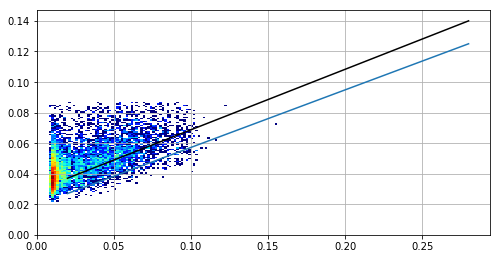

In [10]:
fig = plt.figure(figsize=(9,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=100, range=[[0, np.max(obs_min['warm_frac'])], [0.0, np.percentile(obs_min['dr_rms'], 98)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)

# by eye on midpoint and the bottom edge of the envelope
if limit == 100:
    plt.plot([0.10, 0.44], [0.040, 0.102], 'k')
    plt.plot([0.10, 0.44], [0.028, 0.09])
elif limit == 150:
    plt.plot([0.04, 0.35], [0.04, 0.12], 'k')
    plt.plot([0.04, 0.35], [0.03, 0.11])
elif limit == 200:
    plt.plot([0.02, 0.28], [0.037, 0.14], 'k')
    plt.plot([0.02, 0.28], [0.027, 0.125])
plt.grid()